In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from math import sqrt

## Load Data & Exploratory Data Analysis

Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany. Jena Climate dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

In [2]:
raw_data = pd.read_csv("jena_climate_2009_2016.csv")
raw_data.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
print(raw_data.shape)

(420551, 15)


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [5]:
raw_data['Datetime'] = pd.to_datetime(raw_data['Date Time'], format="%d.%m.%Y %H:%M:%S")
raw_data = raw_data.drop(['Date Time'], axis=1)
raw_data.head(5)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Datetime
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,2009-01-01 00:10:00
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,2009-01-01 00:20:00
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,2009-01-01 00:30:00
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,2009-01-01 00:40:00
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,2009-01-01 00:50:00


## Data Preparation

I will be train a Prophet model on this data. The data preparation steps cover:
* Normalisation
* Renaming the columns to ds and y, which are the required names by Prophet
* Segmenting the train/test data using date range
* Convert the data set from every 10 mins to every 1 hour

### Data Normalisation

In [6]:
from sklearn import preprocessing

temp = raw_data.drop(["Datetime"], axis=1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(temp.values)
normalise_temperature = x_scaled[:,1]

In [7]:
data = pd.DataFrame(raw_data["Datetime"])
data.rename({'Datetime': 'ds'}, axis=1, inplace=True)
data['y'] = normalise_temperature
data.head(10)

,ds,y
0,2009-01-01 00:10:00,0.248632
1,2009-01-01 00:20:00,0.242163
2,2009-01-01 00:30:00,0.240504
3,2009-01-01 00:40:00,0.243822
4,2009-01-01 00:50:00,0.244485
5,2009-01-01 01:00:00,0.248134
6,2009-01-01 01:10:00,0.255266
7,2009-01-01 01:20:00,0.255266
8,2009-01-01 01:30:00,0.250456
9,2009-01-01 01:40:00,0.241831


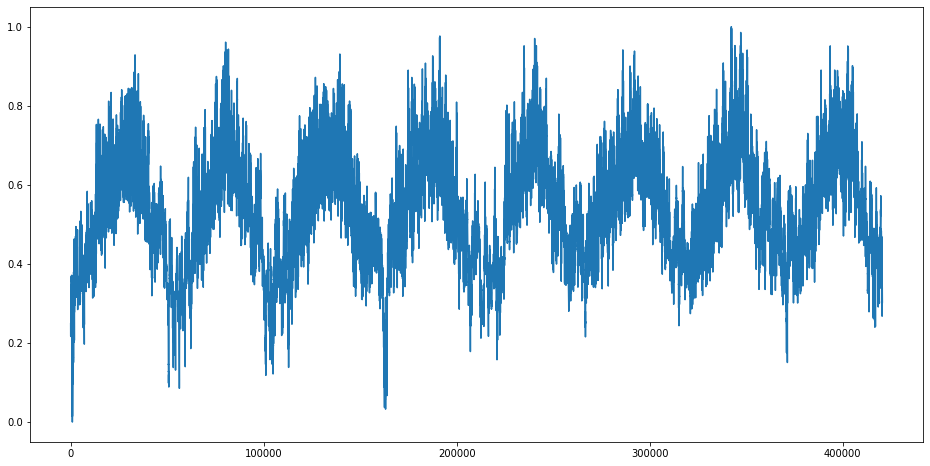

In [8]:
plt.figure(figsize=(16,8))
plt.plot(range(len(data)), data["y"])

In [9]:
date_range = pd.date_range(start='1/1/2009', end='1/1/2017', freq='10T')
date_range[0:420551]

DatetimeIndex(['2009-01-01 00:00:00', '2009-01-01 00:10:00',
               '2009-01-01 00:20:00', '2009-01-01 00:30:00',
               '2009-01-01 00:40:00', '2009-01-01 00:50:00',
               '2009-01-01 01:00:00', '2009-01-01 01:10:00',
               '2009-01-01 01:20:00', '2009-01-01 01:30:00',
               ...
               '2016-12-30 10:10:00', '2016-12-30 10:20:00',
               '2016-12-30 10:30:00', '2016-12-30 10:40:00',
               '2016-12-30 10:50:00', '2016-12-30 11:00:00',
               '2016-12-30 11:10:00', '2016-12-30 11:20:00',
               '2016-12-30 11:30:00', '2016-12-30 11:40:00'],
              dtype='datetime64[ns]', length=420551, freq='10T')

In [10]:
data_prophet = pd.DataFrame({'ds': date_range[0:420551], 'y': data['y']})
data_prophet.head(5)

,ds,y
0,2009-01-01 00:00:00,0.248632
1,2009-01-01 00:10:00,0.242163
2,2009-01-01 00:20:00,0.240504
3,2009-01-01 00:30:00,0.243822
4,2009-01-01 00:40:00,0.244485


Convert the data set from every 10 mins to every 1 hour, then prepare the train and test data

In [11]:
print(data_prophet.shape)
data_prophet = data_prophet.iloc[::6, :]
print(data_prophet.shape)

(420551, 2)
(70092, 2)


In [12]:
train_prophet = data_prophet.iloc[0:50000]
print(train_prophet.shape)
train_prophet.head()

(50000, 2)


,ds,y
0,2009-01-01 00:00:00,0.248632
6,2009-01-01 01:00:00,0.255266
12,2009-01-01 02:00:00,0.234865
18,2009-01-01 03:00:00,0.235031
24,2009-01-01 04:00:00,0.228562


In [13]:
test_prophet = data_prophet.iloc[50001:]
print(test_prophet.shape)
test_prophet.head()

(20091, 2)


,ds,y
300006,2014-09-15 09:00:00,0.625974
300012,2014-09-15 10:00:00,0.623818
300018,2014-09-15 11:00:00,0.620833
300024,2014-09-15 12:00:00,0.620501
300030,2014-09-15 13:00:00,0.616686


## Hyperparameter Tuning on univariate prophet model

There are a few parameters in the Prophet model, many of which comes with default values. To know which is the best values for the parameters, I define a param_grid of all the parameters and values we want to loop through, and then calculated the mean value of the performance matrix. I then get the best parameter combination in terms of RMSE. The outputs of the model parameters and the RMSE will be saved into a csv file.

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'changepoint_prior_scale': [0.005, 0.05, 0.5, 5],
    'seasonality_prior_scale':[0.01, 0.1, 1, 10.0],
    'changepoint_range': [0.8, 0.9]
              }
# param_grid = {  
#                 'changepoint_prior_scale': [0.005, 0.05, 0.5, 5],
#                 'changepoint_range': [0.8, 0.9],
#                 'seasonality_prior_scale':[0.1, 1, 10.0],
#                 'holidays_prior_scale':[0.1, 1, 10.0],
#                 'seasonality_mode': ['multiplicative', 'additive'],
#                 'growth': ['linear', 'logistic'],
#                 'yearly_seasonality': [5, 10, 20]
#                 'n_changepoints' : [25, 100, 200]
#               }

grid = ParameterGrid(param_grid)
print('Total Possible Models: {}'.format(len(grid)))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])

for p in grid:
    print(p)
    random.seed(0)
    
    model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                    seasonality_prior_scale = p['seasonality_prior_scale'],
                    changepoint_range = p['changepoint_range'],
                    interval_width=0.95)
                        
    model.fit(train_prophet)
    
    future = model.make_future_dataframe(periods=test_prophet.shape[0], 
                                         freq='1H')
    forecast = model.predict(future)

    RMSE = sqrt(mean_squared_error(test_prophet.y.values, forecast['yhat'][50000:]))

    print('Root Mean Square Error(RMSE)------------------------------------{}'.format(RMSE))
    model_parameters = model_parameters.append({'RMSE':RMSE,'Parameters':p}, ignore_index=True)

In [ ]:
model_parameters = model_parameters.sort_values(by=['RMSE'])
model_parameters = model_parameters.reset_index(drop=True)
model_parameters.to_csv('model_parameters.csv')
model_parameters

## Prophet Univariate Training & Forecast
Based on the hyper-parameter tuning earlier, the best parameters to set are
* changepoint_prior_scale: 0.005
* changepoint_range: 0.8 
* seasonality_prior_scale: 0.01

In [14]:
%%time

model = Prophet(changepoint_prior_scale = 0.005,
                changepoint_range = 0.8,
                seasonality_prior_scale = 0.01)  

model.fit(train_prophet)

In [15]:
%%time

future = model.make_future_dataframe(periods = test_prophet.shape[0], freq = '1H')  
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = sqrt(mean_squared_error(test_prophet.y.values,forecast['yhat'][50000:]))
print('Prophet RMSE: %.3f' % rmse)

mae = mean_absolute_error(test_prophet.y.values,forecast['yhat'][50000:])
print('Prophet MAE: %.3f' % mae)

In [17]:
model.plot(forecast);

In [18]:
plt.figure(figsize=(12,6))
plt.plot(test_prophet.y.values, label='Original')
plt.plot(forecast['yhat'][50000:].values, ls='--', label="Predicted")
plt.legend(loc='best')
plt.title('FB Prophet Univariate')
plt.show()

In [19]:
model.plot_components(forecast);

## Prophet Multivariate model training

In [17]:
MultiVar4Prophet = pd.DataFrame(x_scaled)
MultiVar4Prophet = pd.concat([raw_data['Datetime'], MultiVar4Prophet], axis=1)
MultiVar4Prophet.columns = ['ds', 'v0', 'y','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11', 'v12']
MultiVar4Prophet.head(5)

In [18]:
print(MultiVar4Prophet.shape)
MultiVar4Prophet = MultiVar4Prophet.iloc[::6, :]
print(MultiVar4Prophet.shape)

In [19]:
trainProphet = MultiVar4Prophet.iloc[0:50000]
print(trainProphet.shape)
trainProphet.head(5)

In [20]:
testProphet = MultiVar4Prophet.iloc[50001:]
testProphet.reset_index(inplace=True)
testProphet.drop('index', axis = 1, inplace=True)
print(testProphet.shape)
testProphet.head(5)

In [21]:
%%time

model = Prophet(changepoint_prior_scale = 0.005,
                changepoint_range = 0.8,
                seasonality_prior_scale = 0.01)

model.add_regressor('v0')
model.add_regressor('v1')
model.add_regressor('v2')
model.add_regressor('v3')
model.add_regressor('v4')
model.add_regressor('v5')
model.add_regressor('v6')
model.add_regressor('v7')
model.add_regressor('v8')
model.add_regressor('v9')
model.add_regressor('v10')
model.add_regressor('v11')
model.add_regressor('v12')

model.fit(trainProphet)
print('Prophet is trained')

In [22]:
%%time

future = model.make_future_dataframe(periods = testProphet.shape[0], freq = '1H')  
forecast = model.predict(testProphet)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(len(testProphet.y.values))
print(len(forecast['yhat']))

rmse = sqrt(mean_squared_error(testProphet.y.values,forecast['yhat']))
print('Prophet RMSE: %.3f' % rmse)

mae = mean_absolute_error(testProphet.y.values,forecast['yhat'])
print('Prophet MAE: %.3f' % mae)